### Coursework 2

In this coursework you will be aiming to complete two classification tasks. 
Both the classification tasks relate to text classification tasks. 

One task is to be solved using Support Vector Machines. The other has to be solved using Boosting.

The specific tasks and the marking for the various tasks are provided in the notebook. Each task is expected to be accompanied by a lab-report. Each task can have a concise lab report that is maximum of one page in an A4 size. You will be expected to submit your Jupyter Notebook and all lab reports as a single zip file. You could have additional functions implemented that you require for carrying out each task.


#### Task 1

In this task, you need to obtain sentiment analysis for the provided dataset. The dataset consists of movie reviews with the sentiments being provided. The sentiments are either positive or negative. You need to train an SVM based classifier to obtain train and check on the sample test dataset provided. The method will be evaluated also against an external test set. Please do not hardcode any dimensions or number of samples while writing the code. It should be possible to automate the testing and hardcoding values does not allow for automated testing. 

You are allowed to use scikit-learn to implement the SVM. However, you are expected to write your own kernels.

You are allowed to use the existing library functions such as scikit-learn or numpy for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom text kernels. Refer to the documentation provided [here](https://scikit-learn.org/stable/modules/svm.html) at 1.4.6.2 and an example [here](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html) for writing your own kernels.

Details regarding the marking have been provided in the coursework specification file. Ensure that the code can be run with different test files. 

#### Process the text and obtain a bag of words-based features 

In [1]:
import nltk
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize
import string
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import RegexpStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from IPython.display import clear_output

nltk.download('punkt')
# nltk.download('wordnet')


STOP_WORDS = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
              "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
              'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself',
              'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
              'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
              'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the',
              'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
              'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
              'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
              'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
              'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
              'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don',
              'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren',
              "aren't", 'couldn', "couldn't", 'didn', "didn't",'hadn', "hadn't",
              'hasn', "hasn't", 'haven', "haven't", 'isn', 'ma', 'mightn', "mightn't", 'mustn',
              'shan', "shan't", 'shouldn', "shouldn't", 'wasn', 
              'weren', "weren't", 'wouldn', "<", ">", "/", "br", "..", "``", "(", ")",'``','thi',"'s"]

def extract_bag_of_words_train_test(train_file, test_file):
    print("Reading training data...")
    
    # Read the CSV file and extract Bag of Words Features
    with open(train_file, encoding="utf-8", mode="r") as file:
        # Remove newline from each line; skip header
        raw_train_data = file.read().split("\n")[1:]
        
    ls = LancasterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    
    train_data = []
    for row in raw_train_data:
        row = row.rstrip(",")  # In case there's a comma at the end of the row
        rightmost_comma = row.rfind(",")
        review = row[:rightmost_comma]
        review = re.sub("[\"\'\`]", "", review)
        sentiment = row[rightmost_comma + 1:]
        word_tokens = word_tokenize(review.replace(",", "").replace(".", ""))
        stemmed_doc = [ls.stem(w) for w in word_tokens]

        filtered_review = " ".join([word for word in stemmed_doc if word.lower() not in STOP_WORDS])
        train_data.append([filtered_review, sentiment])
        
    print("Reading test data...")
    
    with open(test_file, encoding="utf-8", mode="r") as file:
        # Remove newline from each line; skip header
        raw_test_data = file.read().split("\n")[1:]

    test_data = []
    for row in raw_test_data:
        row = row.rstrip(",")  # In case there's a comma at the end of the row
        rightmost_comma = row.rfind(",")
        review = row[:rightmost_comma]
        review = re.sub("[\"\'\`]", "", review)
        sentiment = row[rightmost_comma + 1:]
        word_tokens = word_tokenize(review.replace(",", "").replace(".", ""))
        stemmed_doc = [ls.stem(w) for w in word_tokens]
        
        filtered_review = " ".join([word for word in stemmed_doc if word.lower() not in STOP_WORDS])
        test_data.append([filtered_review, sentiment])

    x_train, y_train = np.array(train_data, dtype=str).T
    x_test, y_test = np.array(test_data, dtype=str).T
    
    vectorizer = TfidfVectorizer()
    x_train = vectorizer.fit_transform(x_train).toarray()
    x_test = vectorizer.transform(x_test).toarray()

    
    # Convert positive/negative to 1/-1 respectively
    for idx, sentiment in enumerate(y_train):
        y_train[idx] = 1 if "p" in sentiment else -1
    for idx, sentiment in enumerate(y_test):
        y_test[idx] = 1 if "p" in sentiment else -1

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    print("x_test shape:", x_test.shape)
    print("y_test shape:", y_test.shape)

    return x_train, y_train, x_test, y_test


[nltk_data] Downloading package punkt to /Users/joetutton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


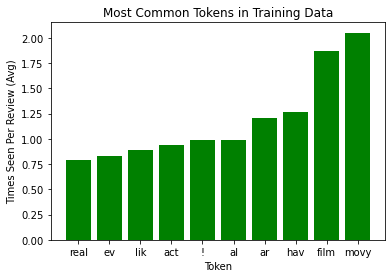

In [3]:
def common_tokens(file_path):
    
    # Read the CSV file and extract Bag of Words Features
    with open(file_path, encoding="utf-8", mode="r") as file:
        # Remove newline from each line; skip header
        raw_train_data = file.read().split("\n")[1:]
        
    ls = LancasterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    
    train_data = []
    for row in raw_train_data:
        row = row.rstrip(",")  # In case there's a comma at the end of the row
        rightmost_comma = row.rfind(",")
        review = row[:rightmost_comma]
        sentiment = row[rightmost_comma + 1:]
        review = re.sub("[\"\'\`]", "", review)
        word_tokens = word_tokenize(review.replace(",", "").replace(".", ""))
        stemmed_doc = [ls.stem(w) for w in word_tokens]
        stemmed_doc = [stemmed_token for stemmed_token in stemmed_doc if ord(stemmed_token[0])!= 96 ]

        filtered_review = " ".join([str(word) for word in stemmed_doc if word.lower() not in STOP_WORDS])
        train_data.append([filtered_review, sentiment])
        
    x_train, y_train = np.array(train_data, dtype=str).T
    token_count = dict()
    num_of_rev = x_train.shape[0]
    for row in x_train:
        word_tokens = word_tokenize(row)
        for word_token in word_tokens:
            token_count[word_token] = token_count.get(word_token,0)+1

    #normailse
    for token_word in list(token_count.keys()):
        token_count[token_word] = token_count[token_word]/num_of_rev
    
    #sort into ascending order
    token_count = dict(sorted(token_count.items(), key=lambda item: item[1]))
    
    top10 = list(token_count.keys())[-10:]
    top10_vals = [token_count[word] for word in top10]


    x_pos = [i for i, _ in enumerate(top10)]
    plt.bar(x_pos, top10_vals, color='green')
    plt.xlabel("Token")
    plt.ylabel("Times Seen Per Review (Avg)")
    plt.title("Most Common Tokens in Training Data")

    plt.xticks(x_pos, top10)

    plt.show()
    
    return token_count
        

    
training_tokens = common_tokens("movie_review_train.csv")

In [4]:
class SVMClassifier:
    def __init__(self):
        self.x_train = None
        self.y_train = None
        self.r = float(1)
        self.C = 1
        self.gamma = float(1)
        self.degree = 2
        self.sc = svm.SVC(C = self.C, kernel = self.linear, gamma = self.gamma, degree= self.degree, max_iter=-1)
        
    def linear(self, X, Y):
        return X.dot(Y.T)
            
    def poly_kernel_fn(self, X, Y):
        K = np.zeros((X.shape[0],Y.shape[0]))
        K = (self.gamma * X.dot(Y.T) + self.r)** self.degree
        return K
    
    def my_kernel(self, X, Y):
        K1 = self.sigmoid(X, Y)
        K2 = self.linear(X, Y)
        K3 = self.poly_kernel_fn(X, Y)
        return K1 + 3 * K3
    
    def sigmoid(self, X, Y):
        K = self.gamma * (X.dot(Y.T)) + self.r
        return np.tanh(K)
    
    def fit(self, x, y):
        
        self.x_train = x
        self.y_train = y
        self.sc.fit(self.x_train, self.y_train)

    def predict(self, x):
        return self.sc.predict(x)
    
    def get_params(self):
        return 

### Test function that will be called to evaluate your code. Separate test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. 

In [5]:
def test_func_svm(dataset_train, dataset_test):
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    sc = SVMClassifier()
    sc.fit(X_train, Y_train)
    Y_Pred = sc.predict(X_test)
    acc = accuracy_score(Y_test, Y_Pred)
    print("Accuracy:", acc)
    return acc

In [6]:
acc = test_func_svm("movie_review_train.csv", "movie_review_test.csv")

Reading training data...
Reading test data...
x_train shape: (5000, 26979)
y_train shape: (5000,)
x_test shape: (1500, 26979)
y_test shape: (1500,)
Accuracy: 0.8666666666666667


In [ ]:
report= classification_report(Y_test, predict,target_names=['Negative','Positive'])
print("Classification Report: \n",report)

### Task 2

In this task you need to implement a boosting based classifier that can be used to classify the images. 

Details regarding the marking for the coursework are provided in the coursework specification file. Please ensure that your code will work with a different test file than the one provided with the coursework.

Note that the boosting classifier you implement can include decision trees from scikit-learn or your own decision trees. Use the same sentiment analysis dataset for evaluation.

In [7]:
class BoostingClassifier:
    # You need to implement this classifier. 
    def __init__(self):
        #implement initialisation
        self.x_train = None
        self.y_train = None
        self.bc = gradient_boost(learning_rate=0.5,number_of_trees=100,max_depth=1)
        
    def fit(self, X, y):
        #implement training of the boosting classifier
        self.x_train = X
        self.y_train = y
        self.bc.fit(self.x_train, self.y_train)
        return 
    def predict(self, X):
        # implement prediction of the boosting classifier
        return self.bc.predict(X)

In [8]:
class gradient_boost:
    def __init__(self,learning_rate,number_of_trees,max_depth,verbose =0):
        self.initial_log_odd = 0
        self.trees = []
        self.leaf_keys = []
        self.number_of_trees = number_of_trees
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.verbose =verbose 
    
    def set_test_data(self, test_X,test_Y):
        self.test_X = test_X
        self.test_Y = test_Y
        
    def predict(self,X):
        log_odds = [self.initial_log_odd for entry in X]
        number_of_predictions = len(log_odds)
        for tree_idx in range(len(self.trees)):
            predictions = self.trees[tree_idx].predict(X)
            log_odds = [log_odds[i]+ (self.learning_rate*self.leaf_keys[tree_idx][predictions[i]]) for i in range(number_of_predictions)]
        
        probs = [np.exp(log_odd)/(1+np.exp(log_odd)) for log_odd in log_odds]
        return [1 if prob > 0.5 else -1 for prob in probs]
        
    
    def fit(self,X,Y):
        if self.verbose >0:
            running_acc = []
        list_y = [0 if rev == -1 else 1 for rev in Y]
        pos_odds = list_y.count(1)/list_y.count(0)
        log_odds = np.log(pos_odds)
        self.initial_log_odd = log_odds

        pos_prob = np.exp(log_odds)/(1+np.exp(log_odds))


        probabilities = [pos_prob for _ in range(len(list_y))]
        log_probabilities = [log_odds for _ in range(len(list_y))]
        residuals = [observation - pos_prob for observation in list_y]

    #     loop
        self.trees = []
        self.leaf_keys = []
        for tree_idx in range(self.number_of_trees):
            clear_output(wait=True)
            print("Tree:",(tree_idx+1),"/",self.number_of_trees)
            self.trees.append(DecisionTreeRegressor(max_depth=self.max_depth))
            self.trees[tree_idx].fit(X, residuals)
            predictions = self.trees[tree_idx].predict(X)
            leafs = dict()
            leaf_vals = dict()
            for i in range(len(predictions)):
                leaf_list = leafs.get(predictions[i],[])
                leaf_list.append(i)
                leafs[predictions[i]]=leaf_list

            for leaf_idx in list(leafs.keys()):
                numerator = 0
                denominator = 0
                for entry_idx in leafs[leaf_idx]:
                    numerator += residuals[entry_idx]
                    denominator += (probabilities[entry_idx]*(1-probabilities[entry_idx]))

                leaf_value = numerator/denominator
                leaf_vals[leaf_idx]=leaf_value
            
            self.leaf_keys.append(leaf_vals)
            
            for entry_idx in range(len(list_y)):
                leaf_update = leaf_vals[predictions[entry_idx]]
                entry_log_odds = log_probabilities[entry_idx]
                entry_log_odds += (self.learning_rate*leaf_update)
                entry_prob = np.exp(entry_log_odds)/(1+np.exp(entry_log_odds))
                entry_residual = list_y[entry_idx]-entry_prob

                log_probabilities[entry_idx]=entry_log_odds
                probabilities[entry_idx] = entry_prob
                residuals[entry_idx] = entry_residual
                
            if self.verbose > 0:
                Y_Pred = self.predict(self.test_X)
                acc = accuracy_score(self.test_Y, Y_Pred)
                running_acc.append(acc)
        if self.verbose > 0:
            return running_acc

In [8]:
class AdaBoost:
    def __init__(self, max_tree_depth=4, num_trees=100):  # Best found parameters
        self.alphas = []
        self.G_M = []
        self.num_trees = num_trees
        self.max_tree_depth = max_tree_depth

    def fit(self, X, y):
        self.y = y
        self.alphas = [] 

        for t in range(self.num_trees):
            clear_output(wait=True)
            print(f"Tree {t + 1}/{self.num_trees}")
            
            # Set weights for current boosting iteration
            if t == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # Update w_i
                w_i = self.update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeClassifier(max_depth=self.max_tree_depth)
            G_m.fit(X, y, sample_weight=w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m)  # Save to list of weak classifiers

            # (b) Compute error
            error_m = self.compute_error(y, y_pred, w_i)

            # (c) Compute alpha
            alpha_m = self.compute_alpha(error_m)
            self.alphas.append(alpha_m)

    def predict(self, X):
        # Initialise dataframe with weak predictions for each observation
        weak_preds = np.zeros((len(X), self.num_trees))

        # Predict class label for each weak classifier, weighted by alpha_m
        for t in range(self.num_trees):
            y_pred_t = self.G_M[t].predict(X) * self.alphas[t]
            weak_preds[:,t] = y_pred_t

        # Calculate final predictions
        y_pred = np.sign(weak_preds.sum(axis=1)).astype(int)
        return y_pred

    def update_weights(self, w_i, alpha, y, y_pred):
        return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))
    
    def compute_error(self, y, y_pred, w_i):
        return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)
    
    def compute_alpha(self, error):
        '''
        Calculate the weight of a weak classifier m in the majority vote of the final classifier. This is called
        alpha in chapter 10.1 of The Elements of Statistical Learning. Arguments:
        error: error rate from weak classifier m
        '''
        return np.log((1 - error) / error)

Code for showing how the number of trees the classifier consists of impacts classification performance

Tree: 100 / 100


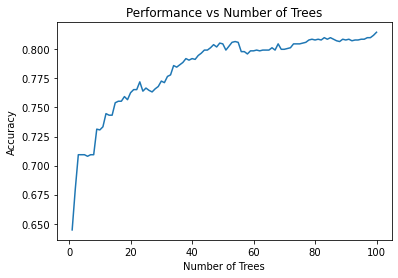

In [35]:
(X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")
bc = gradient_boost(learning_rate=0.25,number_of_trees=100,max_depth=1,verbose =1)
bc.set_test_data(X_test, Y_test)
accs = bc.fit(X_train, Y_train)
plt.plot(range(1,len(accs)+1),accs)
plt.title("Performance vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.show()


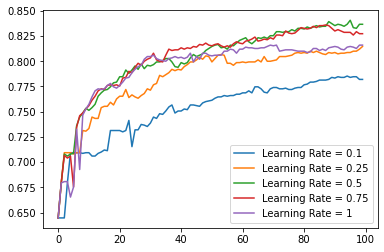

In [9]:
# gradient_boost(learning_rate=,number_of_trees=100,max_depth=1,verbose =1)


# 0.1
learning_rate_01 = np.array([0.64466667, 0.64466667, 0.64466667, 0.67933333, 0.70933333,
       0.70933333, 0.70933333, 0.70933333, 0.70866667, 0.70933333,
       0.70933333, 0.706     , 0.706     , 0.70866667, 0.71      ,
       0.712     , 0.71133333, 0.73133333, 0.73133333, 0.73133333,
       0.73133333, 0.73      , 0.73133333, 0.74133333, 0.71533333,
       0.732     , 0.732     , 0.73733333, 0.73666667, 0.73533333,
       0.73866667, 0.74466667, 0.74333333, 0.748     , 0.74733333,
       0.75066667, 0.75466667, 0.75666667, 0.74866667, 0.75066667,
       0.75066667, 0.75266667, 0.752     , 0.75666667, 0.75666667,
       0.756     , 0.75533333, 0.75866667, 0.76      , 0.76066667,
       0.76133333, 0.76333333, 0.76466667, 0.76466667, 0.766     ,
       0.76533333, 0.766     , 0.766     , 0.76733333, 0.76733333,
       0.76866667, 0.76866667, 0.77066667, 0.76866667, 0.77466667,
       0.77466667, 0.77266667, 0.76933333, 0.76866667, 0.77266667,
       0.774     , 0.774     , 0.77266667, 0.77266667, 0.77333333,
       0.772     , 0.772     , 0.77333333, 0.774     , 0.774     ,
       0.77666667, 0.77733333, 0.77933333, 0.77933333, 0.78      ,
       0.78133333, 0.78133333, 0.78133333, 0.782     , 0.784     ,
       0.78333333, 0.78466667, 0.784     , 0.784     , 0.78533333,
       0.784     , 0.78466667, 0.78466667, 0.782     , 0.782     ])

learning_rate_025 = np.array([0.64466667, 0.67933333, 0.70933333, 0.70933333, 0.70933333,
       0.708     , 0.70933333, 0.70933333, 0.73133333, 0.73066667,
       0.73333333, 0.74466667, 0.74333333, 0.74333333, 0.754     ,
       0.75533333, 0.75533333, 0.75933333, 0.75666667, 0.76266667,
       0.76533333, 0.76533333, 0.772     , 0.764     , 0.76666667,
       0.76466667, 0.76333333, 0.766     , 0.768     , 0.77266667,
       0.77133333, 0.77666667, 0.778     , 0.786     , 0.78466667,
       0.78666667, 0.78866667, 0.792     , 0.79066667, 0.792     ,
       0.79133333, 0.79466667, 0.79666667, 0.79933333, 0.79933333,
       0.80133333, 0.804     , 0.802     , 0.80533333, 0.80466667,
       0.79933333, 0.80266667, 0.806     , 0.80666667, 0.806     ,
       0.798     , 0.798     , 0.796     , 0.79866667, 0.79866667,
       0.79933333, 0.79866667, 0.79933333, 0.79933333, 0.79933333,
       0.80133333, 0.79933333, 0.80466667, 0.8       , 0.8       ,
       0.80066667, 0.80133333, 0.80466667, 0.80466667, 0.80466667,
       0.80533333, 0.806     , 0.808     , 0.80866667, 0.808     ,
       0.80866667, 0.808     , 0.81      , 0.80866667, 0.81      ,
       0.80866667, 0.80733333, 0.80666667, 0.80866667, 0.808     ,
       0.80866667, 0.80733333, 0.808     , 0.808     , 0.80866667,
       0.80866667, 0.81      , 0.81      , 0.812     , 0.81466667])

learning_rate_05 = np.array([0.64466667, 0.67933333, 0.708     , 0.706     , 0.708     ,
       0.70866667, 0.736     , 0.74466667, 0.74866667, 0.75333333,
       0.75133333, 0.754     , 0.75733333, 0.76533333, 0.76866667,
       0.77133333, 0.772     , 0.77466667, 0.77866667, 0.77933333,
       0.78466667, 0.78466667, 0.79133333, 0.788     , 0.79133333,
       0.79533333, 0.792     , 0.79733333, 0.79266667, 0.796     ,
       0.79533333, 0.79666667, 0.79933333, 0.79933333, 0.80066667,
       0.80266667, 0.80266667, 0.79933333, 0.79466667, 0.794     ,
       0.79866667, 0.79733333, 0.79866667, 0.80333333, 0.80666667,
       0.80466667, 0.806     , 0.80733333, 0.81066667, 0.81266667,
       0.81466667, 0.816     , 0.81666667, 0.81333333, 0.814     ,
       0.812     , 0.816     , 0.81533333, 0.818     , 0.82066667,
       0.822     , 0.82333333, 0.81933333, 0.81733333, 0.82      ,
       0.82333333, 0.82266667, 0.824     , 0.82266667, 0.82533333,
       0.82533333, 0.82933333, 0.82933333, 0.82866667, 0.82933333,
       0.82933333, 0.83133333, 0.83      , 0.83266667, 0.83266667,
       0.832     , 0.834     , 0.83266667, 0.834     , 0.83533333,
       0.834     , 0.83466667, 0.83466667, 0.83933333, 0.83733333,
       0.83533333, 0.83666667, 0.836     , 0.83466667, 0.83666667,
       0.84066667, 0.83333333, 0.83266667, 0.83666667, 0.83666667])

learning_rate_075 = np.array([0.64466667, 0.67933333, 0.70666667, 0.704     , 0.706     ,
       0.67533333, 0.73466667, 0.746     , 0.74866667, 0.75266667,
       0.756     , 0.76133333, 0.76533333, 0.77066667, 0.77266667,
       0.772     , 0.776     , 0.77666667, 0.776     , 0.77666667,
       0.77533333, 0.78333333, 0.784     , 0.79      , 0.78866667,
       0.794     , 0.798     , 0.796     , 0.8       , 0.802     ,
       0.80333333, 0.808     , 0.80133333, 0.8       , 0.79933333,
       0.806     , 0.812     , 0.81066667, 0.81133333, 0.81133333,
       0.81333333, 0.812     , 0.81333333, 0.81266667, 0.81466667,
       0.814     , 0.81666667, 0.816     , 0.818     , 0.816     ,
       0.81533333, 0.81666667, 0.81733333, 0.81533333, 0.814     ,
       0.81533333, 0.814     , 0.81733333, 0.81933333, 0.818     ,
       0.81733333, 0.82      , 0.82066667, 0.822     , 0.824     ,
       0.82      , 0.82066667, 0.822     , 0.82133333, 0.82333333,
       0.822     , 0.826     , 0.826     , 0.82533333, 0.83      ,
       0.828     , 0.82733333, 0.828     , 0.83066667, 0.83333333,
       0.83266667, 0.832     , 0.83266667, 0.83466667, 0.83333333,
       0.83533333, 0.83533333, 0.836     , 0.83533333, 0.83266667,
       0.83      , 0.83133333, 0.83      , 0.82866667, 0.82866667,
       0.82866667, 0.826     , 0.82933333, 0.82733333, 0.82733333])

learning_rate_1 = np.array([0.64466667, 0.67933333, 0.68066667, 0.68066667, 0.66533333,
       0.67533333, 0.73266667, 0.69266667, 0.74666667, 0.75266667,
       0.75733333, 0.76466667, 0.77066667, 0.77266667, 0.772     ,
       0.77266667, 0.776     , 0.778     , 0.77466667, 0.77333333,
       0.776     , 0.77933333, 0.78333333, 0.784     , 0.78866667,
       0.792     , 0.79466667, 0.796     , 0.802     , 0.80466667,
       0.80466667, 0.806     , 0.80266667, 0.80133333, 0.80066667,
       0.8       , 0.80266667, 0.80333333, 0.80466667, 0.80333333,
       0.804     , 0.80266667, 0.804     , 0.808     , 0.79933333,
       0.80466667, 0.802     , 0.808     , 0.808     , 0.806     ,
       0.80533333, 0.806     , 0.806     , 0.806     , 0.81      ,
       0.81      , 0.812     , 0.81133333, 0.808     , 0.812     ,
       0.812     , 0.814     , 0.81333333, 0.81333333, 0.81266667,
       0.81266667, 0.81333333, 0.81333333, 0.81466667, 0.816     ,
       0.81533333, 0.816     , 0.81      , 0.81066667, 0.81133333,
       0.81133333, 0.81133333, 0.81066667, 0.81      , 0.81      ,
       0.81      , 0.80866667, 0.80933333, 0.81266667, 0.81266667,
       0.81066667, 0.812     , 0.81066667, 0.81333333, 0.814     ,
       0.81466667, 0.814     , 0.812     , 0.81133333, 0.814     ,
       0.81466667, 0.814     , 0.81266667, 0.816     , 0.816     ])

plt.plot(learning_rate_01, label = "Learning Rate = 0.1")
plt.plot(learning_rate_025, label = "Learning Rate = 0.25")
plt.plot(learning_rate_05, label = "Learning Rate = 0.5")
plt.plot(learning_rate_075, label = "Learning Rate = 0.75")
plt.plot(learning_rate_1, label = "Learning Rate = 1")
plt.legend()
plt.show()

Code for misclassification analysis 

In [ ]:
(X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")
bc = BoostingClassifier()
bc.fit(X_train, Y_train)
Y_Pred = bc.predict(X_test) 


Tree: 55 / 100


In [12]:
def compare_to_train(data_input,train_data,title):
#all misclassified 
    token_count = dict()
    num_of_mis = len(data_input)
    
    for row in data_input:
        word_tokens = word_tokenize(row)
        for word_token in word_tokens:
            token_count[word_token] = token_count.get(word_token,0)+1

    #normailse
    minus_train = dict()
    for token_word in list(token_count.keys()):
        token_count[token_word] = token_count[token_word]/num_of_mis
        minus_train[token_word] = token_count[token_word] - training_tokens.get(token_word,0)
        
    minus_train = dict(sorted(minus_train.items(), key=lambda item: item[1]))
    token_count = dict(sorted(token_count.items(), key=lambda item: item[1]))
    
    top10 = list(token_count.keys())[-10:]
    top10_vals = [token_count[word] for word in top10]
    
    #print graph
    x_pos = [i for i, _ in enumerate(top10)]
    plt.bar(x_pos, top10_vals, color='green')
    plt.xlabel("Token")
    plt.ylabel("Times Seen Per Review (Avg)")
    plt.title("Most Common Tokens in "+title)
    plt.xticks(x_pos, top10)
    plt.show()
    
    top10_minus = list(minus_train.keys())[-10:]
    top10_vals_minus = [minus_train[word] for word in top10_minus]
    
    #print graph
    x_pos = [i for i, _ in enumerate(top10_minus)]
    plt.bar(x_pos, top10_vals_minus, color='green')
    plt.xlabel("Token")
    plt.ylabel("Times Seen Per Review (Avg) - Times Seen Per Review in Training (Avg)")
    plt.title("Most Uniquely Common Tokens in "+title)
    plt.xticks(x_pos, top10_minus)
    plt.show()
    
    

def prediction_misclassification_analysis(X_train, Y_train, X_test, Y_test,Y_Pred,dataset_test,training_tokens):
    
    
    acc = accuracy_score(Y_test, Y_Pred)
    
    misclass_idxs = []
    for i in range(len(Y_test)):
        if Y_test[i] != Y_Pred[i]:
            misclass_idxs.append(i)
    
    misclassed = [x_test[idx] for idx in misclass_idxs] 
    false_pos = []
    false_neg = []
    for idx in misclass_idxs:
        if Y_Pred[idx] == 1:
            false_pos.append(x_test[idx])
        else:
            false_neg.append(x_test[idx])
    
    print("All Misclassified")
    compare_to_train(misclassed,training_tokens,"All Misclassified")
    
    print("Misclassified - False Positive")
    compare_to_train(false_pos,training_tokens,"Misclassified - False Positive")
    
    print("Misclassified - False Negative")
    compare_to_train(false_neg,training_tokens,"Misclassified - False Negative")

prediction_misclassification_analysis(X_train, Y_train, X_test, Y_test,Y_Pred,training_tokens) 
          

### Test function that will be called to evaluate your code. Separate test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. 

In [9]:
def test_func_boosting(dataset_train, dataset_test):
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    bc = BoostingClassifier()
    bc.fit(X_train, Y_train)
    Y_Pred = bc.predict(X_test)    
    acc = accuracy_score(Y_test, Y_Pred)
    return acc